In [112]:
#| default_exp activations

We're missing a way to look inside a model, while training, to diagnose problems.
Without this ability people often randomly try things until something starts working..
We're going to do it properly.

# Activation stats

In [113]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

import matplotlib as mpl
from datasets import load_dataset

from torch import tensor,nn,optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from miniai.datasets import *
from miniai.learner import *

We imported what we just created in the learner.  

In [114]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

We define `set_seed()` with 3 random number generators: Pytorch's, Numpy's, and Python's, and seed all of them.
In Pytorch we can ask it to use a deterministic algorithm, so things should be reproducible.
We shouldn't always make things reproducible, but for lessons this is useful.

In [115]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

### Dataset

Lets use the `fashion_mnist` data set, load it, and create a model similar to our previous models. (might be a bit bigger).

In [116]:
from datasets import load_dataset,load_dataset_builder
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
x,y = ds_builder.info.features

dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline

In [117]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

Let's use `MulticlassAccuracy` and the same callbacks that we used before, and the trainCB version (for no particular reason).

In [118]:
from torcheval.metrics import MulticlassAccuracy, Mean

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

We want to train quickly, i.e., at a high LR.
The higher the LR the more we can find a more generalizable set of weights.
Training quicker means looking at each data item less often, hence fewer issues with overfitting.
If we can train at a high LR we're learning to train in a stable way.
Let's try a high LR of 0.6 and see what happens.
<br>
`fit()` below creates the `Learner` with our callbacks, adding `xtra_cbs`.
We then `fit` it and return the Learner (in case we want to use it).

In [119]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

Below it is training and then it suddenly fells apart,
going well for a while, and then it stopped traning.
Now we have a graph to investigate.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


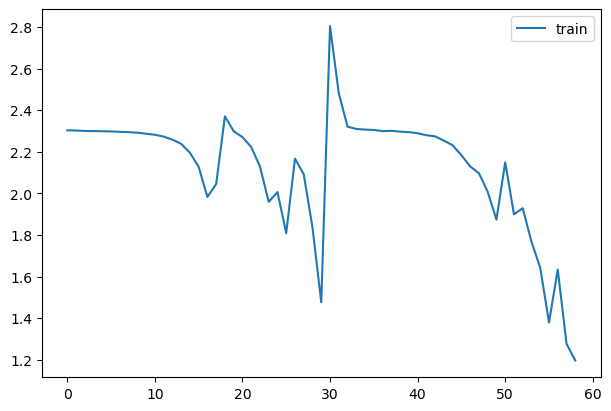

In [120]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

In above graph we see when it stops training well.
Why did it go badly? Was it because of our high LR? 
Let's try to look inside it to find out.

## Hooks

### Manual insertion
One way to look inside it would be to create a `SequentialModel`,
compute for each layer its `mean()` and standard deviation `std()`, 
and append them to a couple of lists, `act_means` and `act_stds`. 
We define `__iter__` to make this class an iterator, to iterate through the layers.

In [121]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds [i].append(to_cpu(x).std ())
        return x
    
    def __iter__(self): return iter(self.layers)

We train this model and it produces an identical output and plots, as we use the same `seed` as before.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


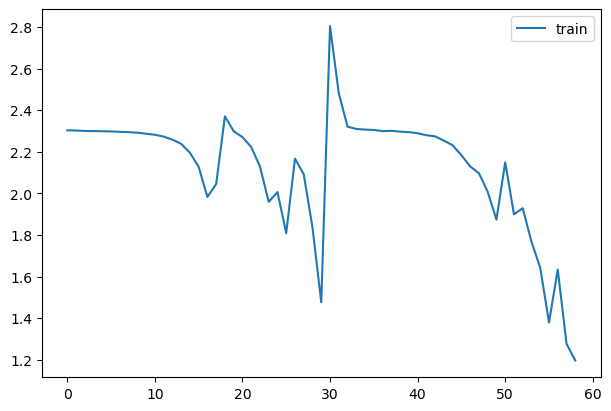

In [122]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

But this time we saved the means `act_means` and the standard deviations of each layer, for every batch, so now we can plot them.
The x-axis is the batch number, and the y-axis the activation means for each layer in different color.

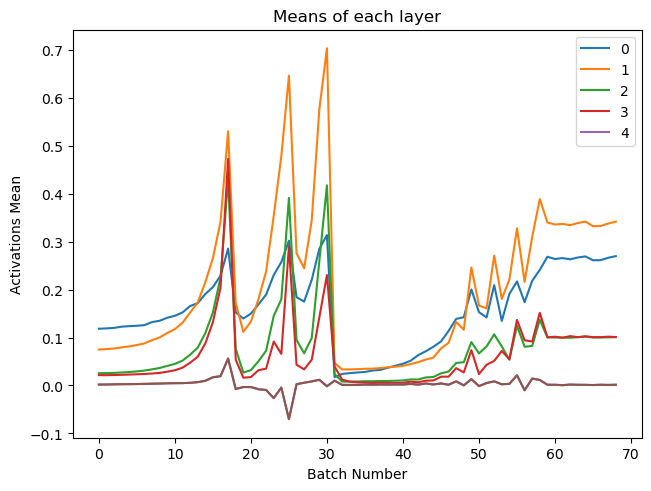

In [123]:
plt.title('Means of each layer')
plt.xlabel('Batch Number')
plt.ylabel('Activations Mean')

for l in model.act_means: plt.plot(l)
plt.legend(range(5));

The activations started small close to zero, increased exponentially and then crashed, (before batch # 20).
They increased again exponentially, each time higher than before, and crashed again, and again.
When activations are close to 0, the inputs to each layer are numbers close to 0, 
then the outputs are close to 0 (we're doing just matrix multiplies).
When activations are very close to zero they're "dead units", not able to do anything.
<br>
NB: 0 mean is OK as long as they're **spread around zero.**
After batch 30 all of the activations are close to 0.

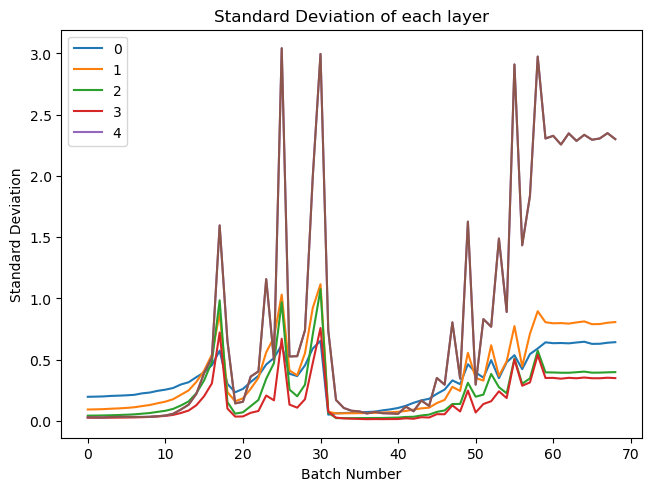

In [124]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));
plt.title('Standard Deviation of each layer')
plt.xlabel('Batch Number')
plt.ylabel('Standard Deviation');

The standard deviations tell an even stronger story.
We want the means of the activations to be about 0 and the stds to be about 1.
0 mean is OK if they're spread around zero.
But a standard deviation close to 0 is terrible, because all activations are about the same.
After batch 30 all of the activations are close to 0, and all of the standard deviations are close to 0, 
so all numbers are about zero, so nothing is going on.
<br>
The same pattern as before is happening in the standard deviations. 
We start with little variety in the weights, it exponentially increases variety, 
and then it crashes again, exponentially increases, crashes again.
<mark> This is a classic shape of bad behavior.</mark>

Above 2 plots explain what's going on in the model.
After we train a model we can look at such plots to see if the model is training "nicely" ("nice" training pictures later).
If the mean is always about 0 and the variance always about 1,
there is a good chance we're training properly, else, we're certainly not.

### Pytorch hooks

Now lets do this in a more elegant way, with Pytorch hooks, an object that we can add to any `nn.Module`.
A **hook** is called when a registered layer is executed during the forward pass 
(forward hook) or the backward pass (backward hook).
Using hooks we don't have to rewrite the model, we can add them to any existing model.
<br>
Pytorch "hooks" and callbacks are very similar.
Hooks are less flexible than the Learner's callbacks 
because hooks don't have access to all the available states, hence can't change things.
Hooks are a kind of callback that just sets a function to be run when something happens, 
e.g., a layer in the forward or backward pass.
(We can say the function that's being called back is the Callback, and the thing that's doing the Callback is the hook.)

Lets use a standard `nn.Sequential` passing in the `cnn_layers`.

In [125]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

To keep track of the activation means and standard deviations, we create empty lists for means and stds for each layer in the model.

In [126]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook function, e.g., `append_stats` is attached to a layer, and needs to have a function signature that takes 3 arguments: module `mod`, input `inp`, output `outp`.  
It store the outputs `mean()` in `act_means` and the output standard deviation in `act_std`.

In [127]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

For each layer of the model we call [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=register#torch.nn.Module.register_forward_hook) to register a function that will be called every time a `forward()` has computed an output.
`append_stats` is the hook function that will be called, passing `i` as the first argument (via `partial`).

In [128]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

We now fit that model, it trains in the usual way, but after each layer it's
going to call the `append_stats` hook.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


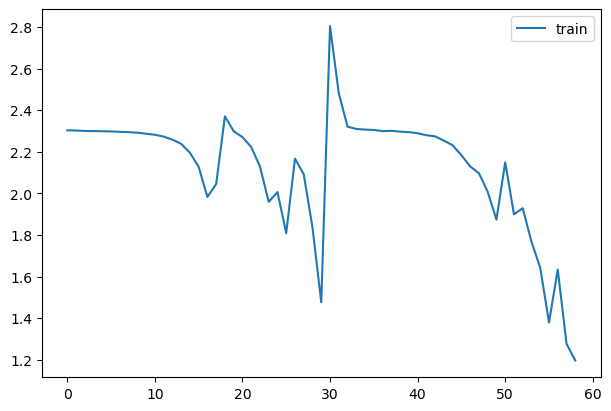

In [129]:
fit(model);

We get the same results and plot as before, but now we can also take a look at the statistics.

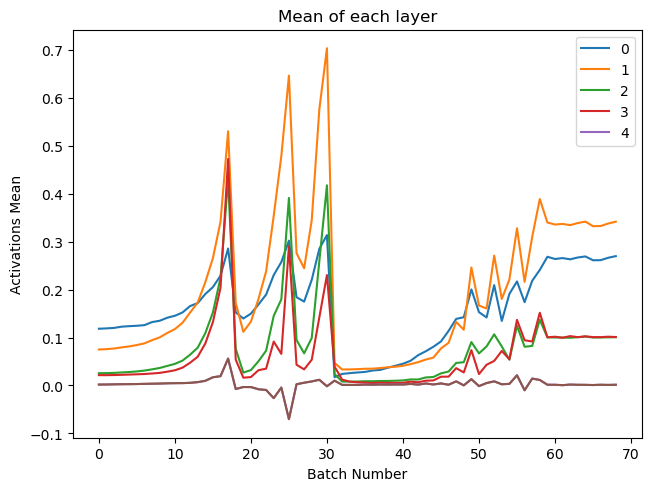

In [130]:
for o in act_means: plt.plot(o)
plt.legend(range(5));
plt.title('Mean of each layer')
plt.xlabel('Batch Number')
plt.ylabel('Activations Mean');

### Hook class

Lets refactor and define a Hook class. 
To register a hook for a module `m` we call `m.register_forward_hook`.
We pass-in both the (callback) function, e.g., `f=append_stats`, and also pass the class via `self`.
We define a `remove()` since we need to remove the hooks when they are deleted, otherwise memory won't be released when the model is deleted. 
The `__del__` is called by Python when an object is freed, so when that happens we make sure that we remove this.

In [131]:
#|export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

The new `append_stats` is going to get the hook (we asked to be passed in the registration above).
If there's no `stats` attribute yet then let's create one inside this object (is convenient).
The `outp` activations are put in `acts` on the CPU, then append to the `stats` the `acts` `.mean()` and `.std()`.

In [132]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [133]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

We instantiate `hooks` for the first 5 `children()` modules of the `model`

In [134]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

Now we can do the same thing as before but we don't have to set any of that `Global` stuff.
When we fit that it's going to run with the hooks.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


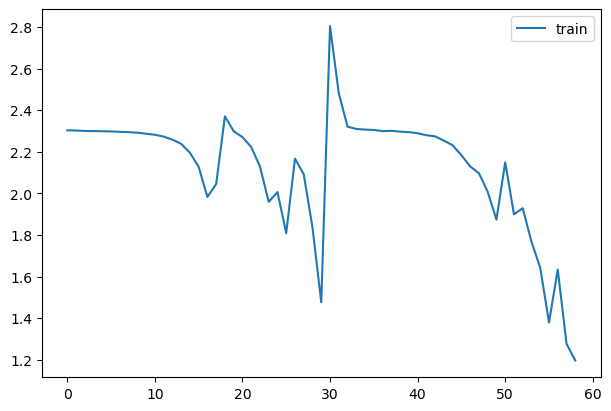

In [135]:
learn = fit(model)

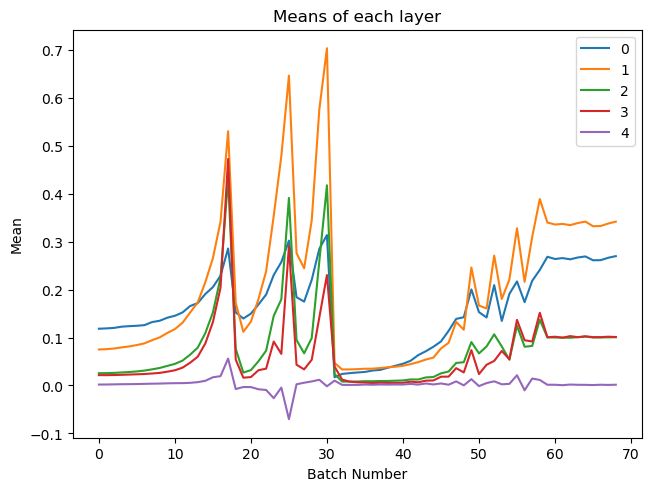

In [136]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));
plt.title('Means of each layer')
plt.xlabel('Batch Number')
plt.ylabel('Mean');

We get the same shape and the same results.

### A Hooks class
We're going to be adding multiple Hooks, and the list comprehension 
`hooks = [Hook(l, append_stats) for l in model[:5].children()]`
is a bit inconvenient.
Let's define a `Hooks` class.
But before that some preliminaries.

#### Preliminaries

Below is a dummy context manager, `DummyCtxMgr`.
It's got `__enter__` which is going to return itself, and it's going to print something.
The second thing it's going to do is call the `dcm.hello()` code inside the context manager.
`dcm` is itself and so it's going to call `hello(self)` which prints "hello.".
Finally it's going to automatically call `__exit__`  which prints "all done!".

In [137]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    def __exit__ (self, *args): print("all done!")
    def hello(self): print("hello.")

Below we call `with DummyCtxMgr()` and so it prints "let's go!" first, etc.

In [138]:
with DummyCtxMgr() as dcm: dcm.hello()

let's go!
hello.
all done!


#### what it's like to inherit from list. 
`DummyList(list)` is inheriting from list and we redefine how `__delitem__` works. 

In [139]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

We create a `Dummylist` as usual.

In [140]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

But if we delete `del` an item it calls the overridden `__delitem__` version, which prints a message
and then calls the original `super().__delitem__(i)`
The list got removed that item and did this at the same time.

In [141]:
del(dml[2])
dml

Say bye to item 2


[1, 3]

### The Hooks class

A Python context manager is a class that defines `__enter__` and `__exit__`.
The `Hooks` class inherits from `list`.
*(In Python, we can inherit from stuff like list).*
Because `Hooks` is a subclass of `list`, in `__init__` we need to call the `super()` class Constructor.
We pass-in a list comprehension the hook function `f` and the modules `m` we ask to hook into.
`super().__init__([Hook(m, f) for m in ms])`
We're passing in a `nn.sequential` model, hence we can loop through it and it returns each of the layers.
`__exit__` is called automatically at the end of the whole block.
It calls `remove` that removes each hook `h`.
We also added an optional `__delitem__` to delete a single `Hook` from the list.

In [142]:
#|export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [143]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

Now lets see how the `Hooks` class works, making it a context manager.
We're going to call, pass in the `model`, pass in the function to use `append_stats`, 
and then `fit(model)`. 
`__enter__` is called when it hits the with statement.
If we add an `as xxxx` after it then the contents of the `xxxx` variable 
will be whatever is returned from `__enter__`.
Here we just returned the object itself, so the the `Hooks` object is going to be stored in `hooks`.
<br>
Just one line of code  to set up the context manager: `with Hooks(model, append_stats) as hooks:`
Then we can go through each hook `h` and plot the `stats` (mean and standard deviation) of each layer. 

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


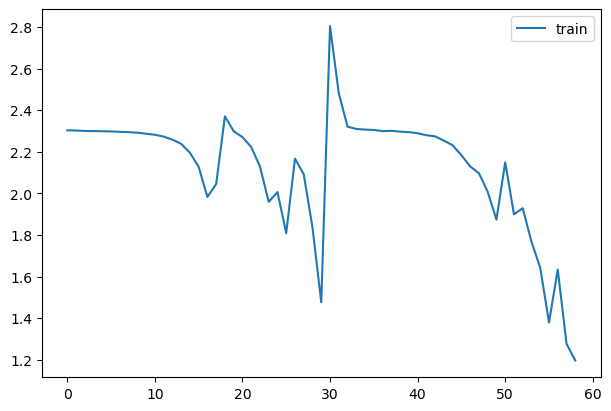

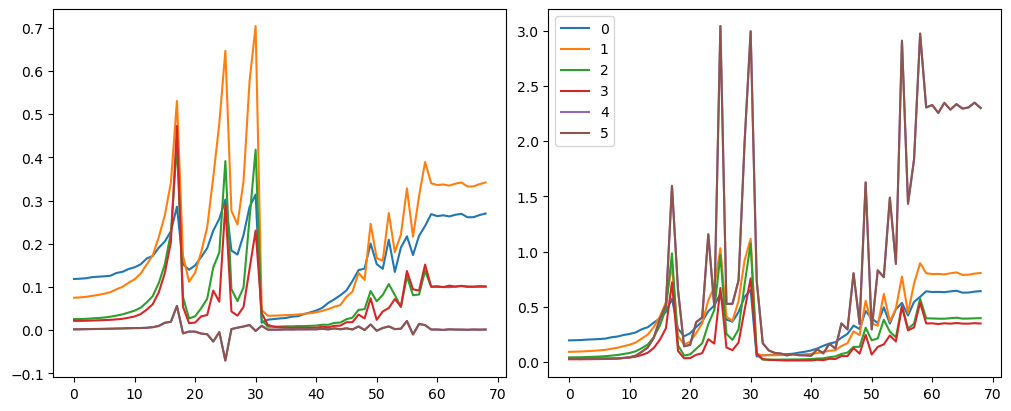

In [144]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### HooksCallback

We had a `Hooks` class, and now we simplify by putting hooks in a `HooksCallback(Callback)`.
We pass the constructur the callback function (`hookfunc`) that will be called for the hook,
and an optional filter, `mod_filter`, as to what modules you want to hook.
In `before_fit` it will filter the modules in the learner with `fc.filter_ex(learn.model.modules(), self.mod_filter)`
<br>
We add a `_hookfunc` function to check if `learn.training`, and if so it calls `hookfunc`
`after_fit` it calls `hooks.remove()` to remove the hooks.
We can iterate through the `hooks` and get the length of the `hooks` 
because it just passes these iterators and length down to `self.hooks`. 

In [145]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

Lets create a hooks callback`hc`, with `append_stats`, and a filter to apply i.e., only the `conv2d` layers.
We then run the model.

In [146]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

In [147]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

We add `hc` as an extra callback `xtra_cbs` to `fit`. 
Now we've we can iterate through it and plot in the usual way.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


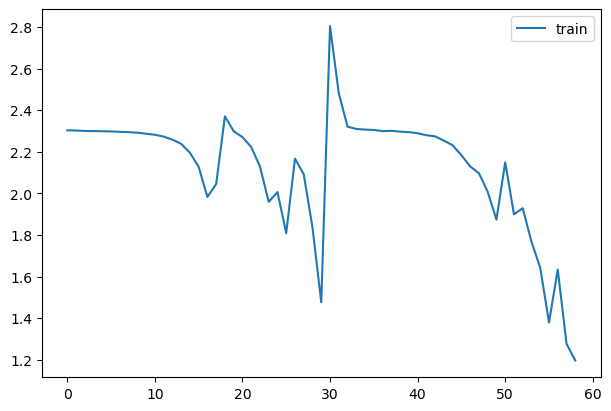

In [148]:
fit(model, xtra_cbs=[hc]);

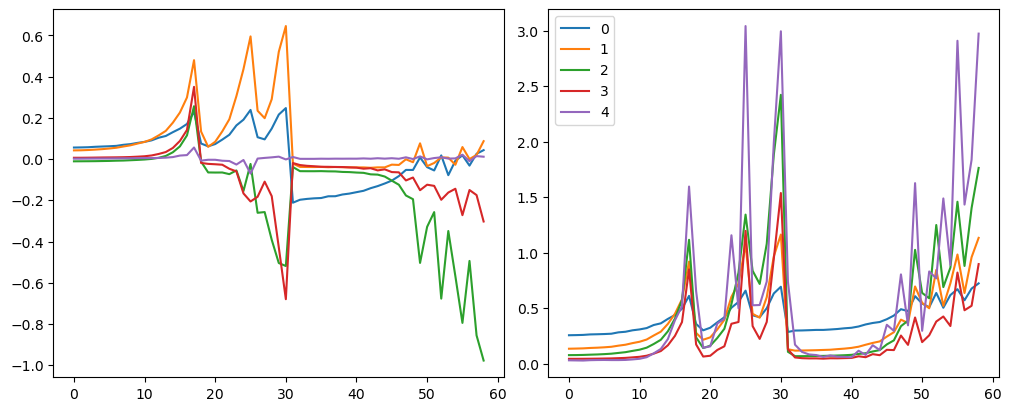

In [149]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms - the *colorful dimension*

JH favorite single image explanations of what's going on inside a model: the *colorful dimension* histograms.
We take `append_stats` (as before) and use [torch.histc](https://pytorch.org/docs/stable/generated/torch.histc.html) 
to get a histogram of the absolute values of the activations.
(a histogram takes a collection of numbers and tells how frequent each group of numbers are).
We're going to create 50 (??) bins for our histogram.
We use our hooks that we just created and a new version of `append_stats`. 

In [150]:
#|export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

so it's going to train as before, but now in addition it will have in `stats[2]` a histogram.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


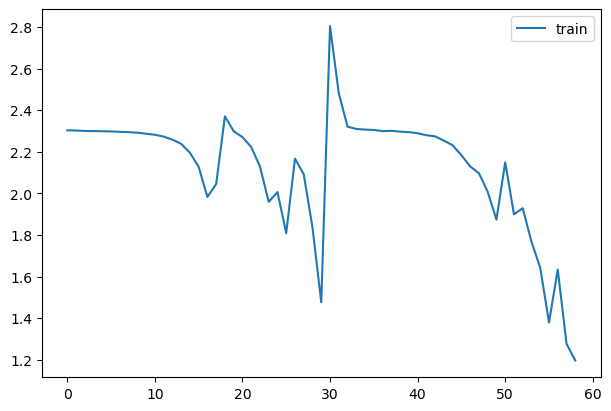

In [151]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [152]:
#|export
# Thanks to @ste for initial version of histogram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

The plot below is showing is for each of the layers what does the training "look like".
There is soame pattern among them, but what is this pattern showing?
We turn the histogram into a single column of pixels.
If I take one column of pixels, that's actually one histogram.

We take the numbers of the histogram, e.g., 14 2 7 9 11 3 2 4 2. 
We turn it into a single column, in this case there are 9 numbers so we have nine groups.
We take the first group (it's 14) and we color it with a gradient according to how big that number is.
14 is a big number, so we use red. 
Next (2) really small which might be green.
Then (7) in the middle blue, (9) is bigger red, (11) bigger more red, and so forth.

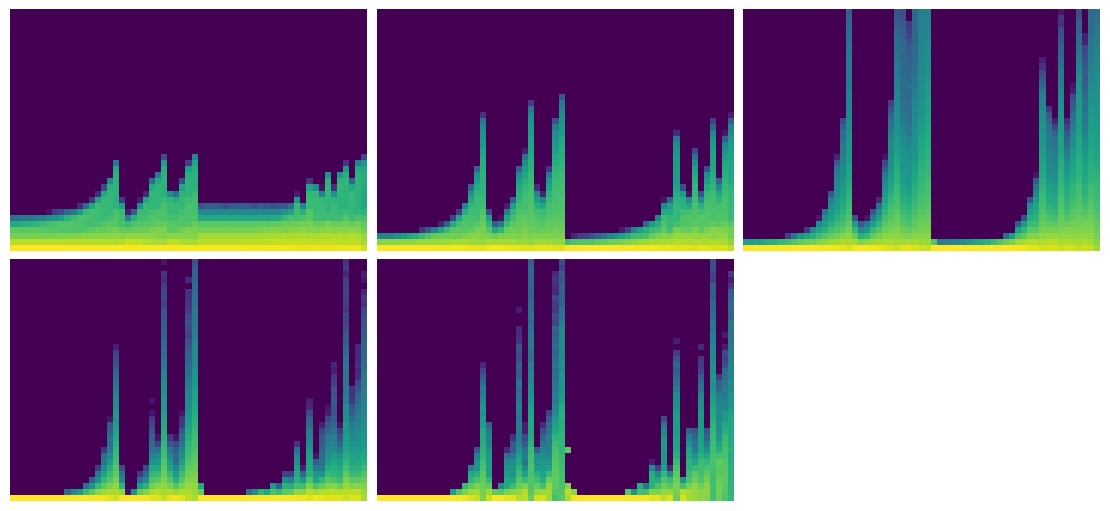

In [153]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

We are taking the histogram and making it into a color-coded single column plot.
Let's take a layer, number two.
We can take the very first column and so in the color
scheme that matplotlib picked, yellow is the most common, then light green is less common,
and then light blue, and then dark blue is zero.
The vast majority is zero and there's a few with slightly bigger numbers, the same that we saw earlier.
The average is close to zero, the standard deviation is small.
This is giving us more information, so as we train at this point here (first peak)
quite a few activations that are a lot larger, still the vast majority of them are very small.
But there's a few big ones so it has a bright yellow bar at the bottom.

```Python
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()
```
We took those histograms, stacked them all up into a single tensor, and then took their `log1p`.
log1p(x) = log(x+1).
That's because we've got zeros here and so just taking the log is going to let us see the full range more clearly.
<br>
Ideally we want to see here is more like a rectangle.
The maximum should not be changing very much.
There shouldn't be a thick yellow bar at the bottom, but instead it should be a nice even gradient, matching a normal distribution.
Each single column of pixels wants to have a normal distribution, gradually decreasing the number of activations.
That's what we're aiming for.

Another way to take the ratio of the very first smallest histogram bin to the rest of the bins, `h1[0]/h1.sum(0)`.
These are very *dead* at this point. 
Taking this ratio tells us what percentage have (near) zero or extremely small magnitudes.
These are absolute values so if we plot those we can see how bad this is.
For example the final layer from the very start nearly all of the activations are disabled.
If most of our model is close to 0 then most of it is doing no work.
So it may look like at the very end things were improving...
But as you can see from this chart that's not true.
Still the vast majority are inactive.

If early in training we see a rising, crash, rising, crash pattern, we should stop and restart training.
Such a model will probably never recover, as too many of the activations have gone off the rails.
So we want it to look kind of like this the whole time but
with less of this very thick yellow bar which is showing us most are inactive.

In [154]:
#|export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

so the graphs really look like very dead at this point.

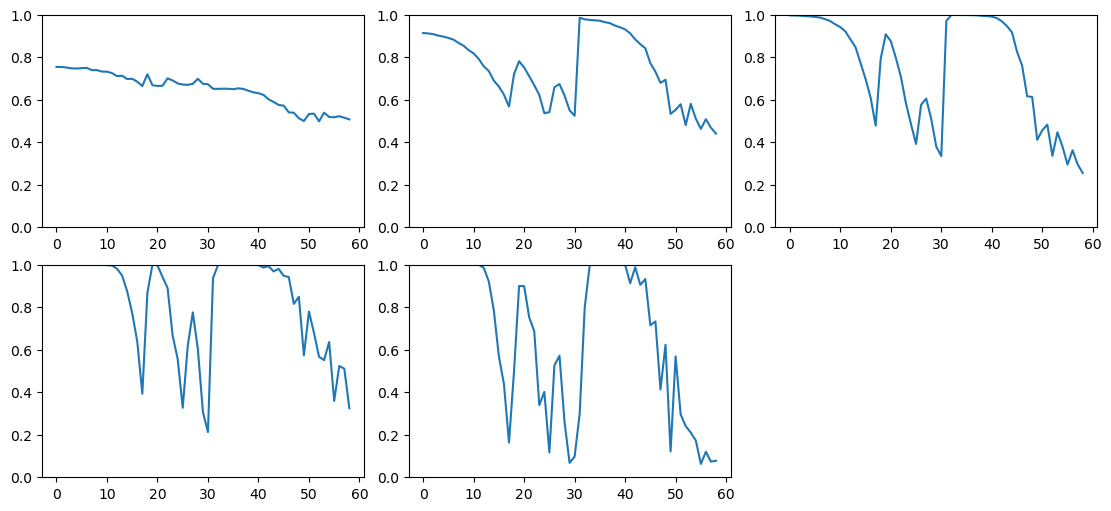

In [155]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

## ActivationStats

Lets take `color_dim` and wrap it in a callback: `ActivationStats(HooksCallback)`
which uses `append_stats` to append the means, stds and histograms.
Added the `color_dim` method, a `dead_chart` method and a `plot_stats` method.

In [156]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

To see them at work, if we want to get the activations on and all of the cons, 
then we train our model, created our `ActivationStats`, added `astats` as an extra callback,
and then we can call `astats.color_dim(), astats.dead_chart()` and `astats.plot_stats()` to get each plot.

In [157]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


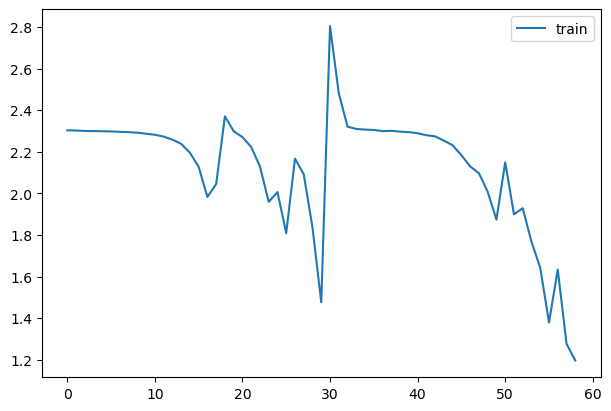

In [158]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

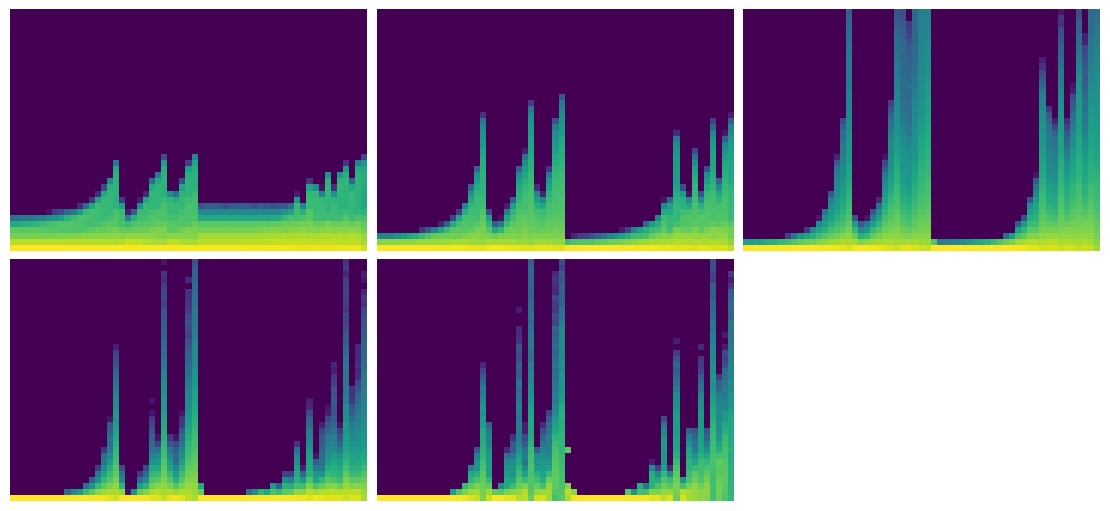

In [159]:
astats.color_dim()

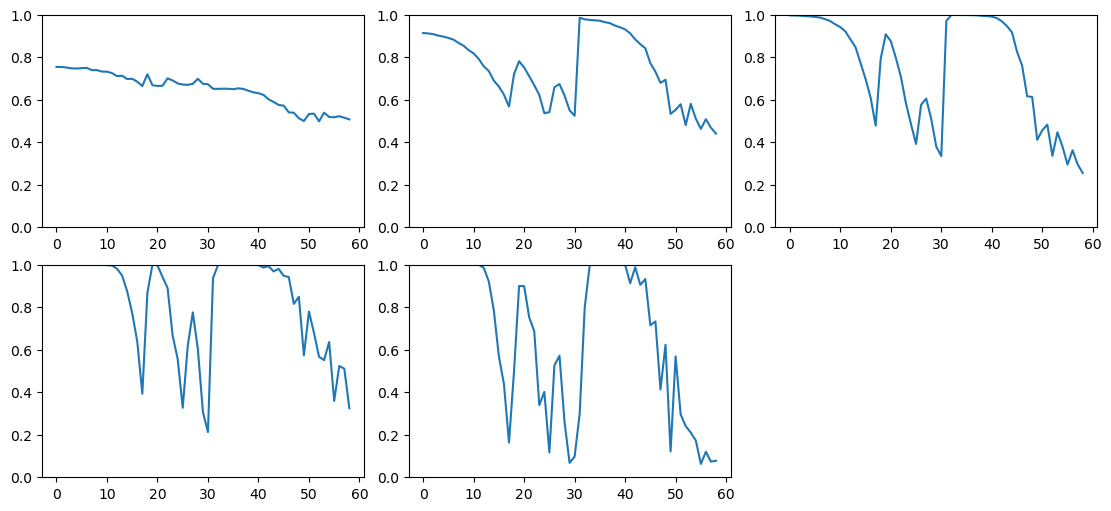

In [160]:
astats.dead_chart()

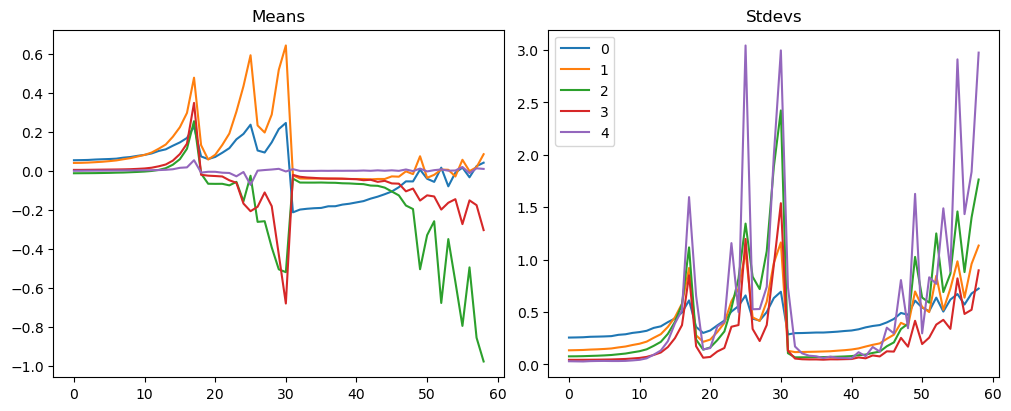

In [161]:
astats.plot_stats()

Now we can get all of these informative visualizations of what's going on inside our model. 
It's just adding one line of code and putting that in our callbacks.
Even for models we thought were training really well we can try using this and
might be surprised to discover that they're not okay... 

## Export -

In [162]:
import nbdev; nbdev.nbdev_export()